In [1]:
%matplotlib inline
%mkdir figures
%load_ext autoreload
%autoreload 2
# GA champ - due to ability to retain good results and not be affected as much by random steps
import importlib
import mlrose
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
prob_name = "kcolor"
np.random.seed(1)

mkdir: cannot create directory ‘figures’: File exists


In [13]:
kcolor_edges = 500
kcolor_nodes = 50
from networkx import nx
G = nx.gnm_random_graph(kcolor_nodes, kcolor_edges)
edge_list = G.edges()
degrees = G.degree().values()
max_deg = max(degrees)
k = int(max_deg/5)
print(k)
trials = 100

# Note - max_fitness = # edges = 300
fitness = mlrose.MaxKColor(edge_list)

# Generates many invalid inputs
state = np.random.randint(0, max_deg, (trials, kcolor_nodes))
# Clock evaluation of the fitness to assess 'cost' of fitness function - for loop used because mlrose doesn't appropriately 
time_start = datetime.now()
for trial in range(trials):
    fitness.evaluate(state[trial])
print("Fitness eval time approximately: {}".format((datetime.now() - time_start)/trials))

5
Fitness eval time approximately: 0:00:00.000203


In [14]:
problem = mlrose.DiscreteOpt(length=kcolor_nodes, fitness_fn=fitness, maximize=True, max_val=k) # Note values are count
# max_val is exclusive


In [15]:
# Wrapper for analysis, returns average time over trials and average best fitness
def algo_wrap(algo, trials=100, name="", verbose=False, **kwargs):
    if algo == None:
        raise Exception("Need an input algo")
    time_start = datetime.now()
    best_state, best_fitness  = zip(*[algo(problem, **kwargs) \
                                     for i in range(trials)])
    average_time = ((datetime.now() - time_start)/trials).microseconds
    average_best_fitness = sum(best_fitness) / trials
    if verbose:
        print("{} time approximately: {}".format(name, average_time))
        print("{} Example Best State: {}".format(name, best_state[0]))
        print("{} Average Best Fitness: {}".format(name, average_best_fitness))
    return average_time, average_best_fitness

# Wrapper for looping over hyperparams - returns dictionary of times/fitnesses per hyperparam - presume default hyperparams elsewhere
def eval_wrap(algo, default_params, hyperparams, verbose=False, trials=100):
    ret = {}
    for p in hyperparams:
        ret[p] = []
        input_params = default_params
        ret[p].append(np.empty_like(hyperparams[p])) # time
        ret[p].append(np.empty_like(hyperparams[p])) # fitness
        for i, setting in enumerate(hyperparams[p]):
            print(setting, p)
            input_params[p] = setting
            ret[p][0][i], ret[p][1][i] = algo_wrap(algo, verbose=verbose, trials=trials, **input_params)
    return ret

# Save figures, then plot them - names required for bar graphs
def plot_all(problem_name, algo_name, hyperparams, names, stats):
    for i, param in enumerate(stats):
        plt.clf()
        plt.xlabel(param)
        plt.ylabel(u'Time (\u03bcs)')
        if param in names: # check if we provided custom names (probably bar) type of example hyperparam bar graph
            ind = np.arange(len(hyperparams[param]))
            plt.xticks(ind, names[param])
            plt.bar(ind, stats[param][0])
        else:
            plt.plot(hyperparams[param], stats[param][0])
        plt.title("{} {} Time v {}".format(problem_name, algo_name, param))
        plt.savefig("figures/{}_{}_{}_time.png".format(problem_name, algo_name, param))
        plt.clf()
        if param in names: # check type of example hyperparam bar graph
            ind = np.arange(len(hyperparams[param]))
            plt.xticks(ind, names[param])
            plt.bar(ind, stats[param][1])
        else:
            plt.plot(hyperparams[param], stats[param][1])
        plt.xlabel(param)
        plt.ylabel("Fitness")
        plt.title("{} {} Fitness v {}".format(problem_name, algo_name, param))
        plt.savefig("figures/{}_{}_{}_fitness.png".format(problem_name, algo_name, param))
    # Now for the sake of the notebook, plot in subplots
    plt.clf()
    fig, axes = plt.subplots(len(stats.keys()), 2, figsize=(12,8))
    plt.tight_layout(h_pad=5, w_pad=2)
    fig.suptitle("{} {}".format(problem_name, algo_name))
    fig.subplots_adjust(top=0.88)
    for i, param in enumerate(stats):
        axes[i,0].set_xlabel(param)
        axes[i,1].set_xlabel(param)
        axes[i,0].set_ylabel(u'Time (\u03bcs)')
        axes[i,1].set_ylabel('Fitness')
        axes[i,0].set_title("Time v {}".format(param))
        axes[i,1].set_title("Fitness v {}".format(param))
        if param in names: # check type of example hyperparam bar graph
            ind = np.arange(len(hyperparams[param]))
            axes[i,0].bar(ind, stats[param][0])
            # No labels here, this is too annoying
        else:
            axes[i,0].plot(hyperparams[param], stats[param][0])
        if param in names: # check type of example hyperparam bar graph
            ind = np.arange(len(hyperparams[param]))
            axes[i,1].bar(ind, stats[param][1])
        else:
            axes[i,1].plot(hyperparams[param], stats[param][1])

In [16]:
# Randomized Hill Climbing
max_attempt_range = range(3,33, 3)
max_iter_range = range(20, 1020, 40)
restarts = range(0, 5, 1) # we expect no change because there are no local maxima
default_params = {'max_attempts': 10, 'max_iters': 1000}
hyperparams = {'max_attempts': max_attempt_range, 'max_iters': max_iter_range, 'restarts': restarts}

In [17]:
load_rhc = False
algo_name = "rhc"
fn = '{}_{}_stats.pickle'.format(prob_name, algo_name)

rhc_ret = None
if load_rhc:
    with open(fn) as f:
        rhc_ret = pickle.load(f)
else: 
    rhc_ret = eval_wrap(mlrose.random_hill_climb, default_params, hyperparams, trials=10)
    with open('{}_{}_stats.pickle'.format(prob_name, algo_name), 'wb') as handle:
        pickle.dump(rhc_ret, handle)

3 max_attempts
6 max_attempts
9 max_attempts
12 max_attempts
15 max_attempts
18 max_attempts
21 max_attempts
24 max_attempts
27 max_attempts
30 max_attempts
20 max_iters
60 max_iters
100 max_iters
140 max_iters
180 max_iters
220 max_iters
260 max_iters
300 max_iters
340 max_iters
380 max_iters
420 max_iters
460 max_iters
500 max_iters
540 max_iters
580 max_iters
620 max_iters
660 max_iters
700 max_iters
740 max_iters
780 max_iters
820 max_iters
860 max_iters
900 max_iters
940 max_iters
980 max_iters
0 restarts
1 restarts
2 restarts
3 restarts
4 restarts


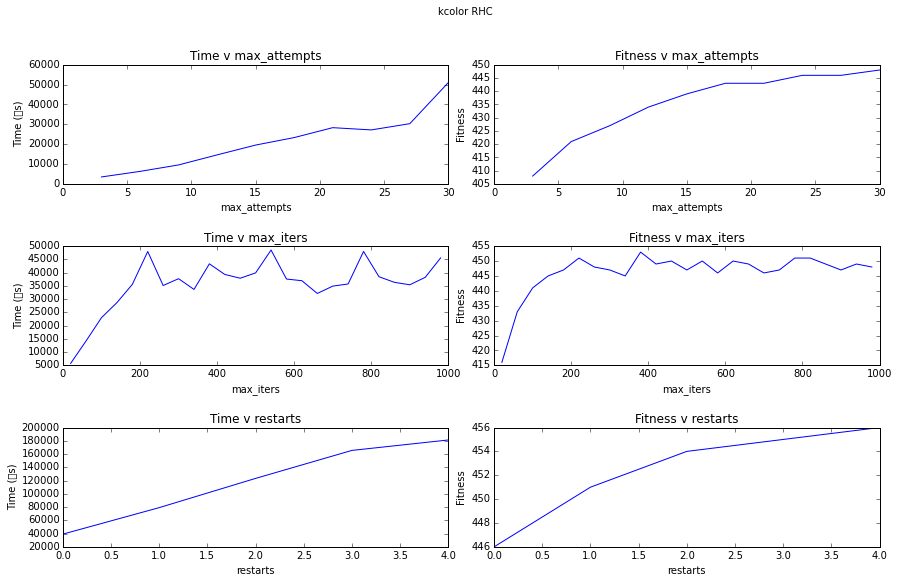

In [18]:
plot_all(prob_name, "RHC", hyperparams, {}, rhc_ret)

In [8]:
# Simulated Annealing
schedules = [mlrose.ExpDecay(), mlrose.GeomDecay(), mlrose.ArithDecay()]
names = {"schedule": ["exp", "geom", "arith"]}
max_attempt_range = range(3,33, 3)
max_iter_range = range(20, 1020, 40)
default_params = {'max_attempts': 10, 'max_iters': 1000, 'schedule': schedules[1]}
hyperparams = {'max_attempts': max_attempt_range, 'max_iters': max_iter_range, 'schedule': schedules}

In [9]:
load_sa = False
algo_name = "sa"
fn = '{}_{}_stats.pickle'.format(prob_name, algo_name)

sa_ret = None
if load_sa:
    with open(fn) as f:
        sa_ret = pickle.load(f)
else: 
    sa_ret = eval_wrap(mlrose.simulated_annealing, default_params, hyperparams)    
    with open('{}_{}_stats.pickle'.format(prob_name, algo_name), 'wb') as handle:
        pickle.dump(sa_ret, handle)

3 max_attempts
6 max_attempts


KeyboardInterrupt: 

In [ ]:
plot_all(prob_name, "SA", hyperparams, names, sa_ret)

In [ ]:
from deap import base, creator, tools, algorithms
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=kcolor_nodes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
def evaluate(state): # Pulled from mlrose
    fitness = 0

    for i in range(len(edge_list)):
        # Check for adjacent nodes NOT of the same color
        if state[edge_list[i][0]] != state[edge_list[i][1]]:
            fitness += 1

    return fitness,
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
toolbox.register("select", tools.selTournament, tournsize=3)

# plot_all("one_max", "GA", hyperparams, names, ga_ret)

In [ ]:
pop = toolbox.population(n=100)
# hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, verbose=False)
avg_, max_ = logbook.select("avg", "max")
print(avg_[-1], max_[-1])

In [ ]:
# Yep, we're still copy-pasting
# Wrapper for analysis, returns average time over trials and average best fitness
# Not super generic, we're still getting two stats
def algo_wrap_generic(algo, stats_fn, trials=100, name="", **kwargs):
    if algo == None:
        raise Exception("Need an input algo")
    time_start = datetime.now()
    avg_, max_  = zip(*[stats_fn(algo(**kwargs)) \
                                     for i in range(trials)])
    avg_avg = sum(avg_) / trials
    avg_max = sum(max_) / trials
    return avg_avg, avg_max

# Wrapper for looping over hyperparams - returns dictionary of times/fitnesses per hyperparam - presume default hyperparams elsewhere
def eval_wrap_generic(algo, stats_fn, default_params, hyperparams, verbose=False, trials=100):
    ret = {}
    for p in hyperparams:
        ret[p] = []
        input_params = default_params
        ret[p].append(np.empty_like(hyperparams[p])) 
        ret[p].append(np.empty_like(hyperparams[p]))
        for i, setting in enumerate(hyperparams[p]):
            print(setting, p)
            input_params[p] = setting
            ret[p][0][i], ret[p][1][i] = algo_wrap_generic(algo, stats_fn, trials=trials, **input_params)
    return ret

# Save figures, then plot them - names required for bar graphs
def plot_genetic(problem_name, algo_name, hyperparams, names, stats):
    for i, param in enumerate(stats):
        plt.clf()
        plt.xlabel(param)
        plt.ylabel('')
        plt.plot(hyperparams[param], stats[param][0], linestyle='--', color='cornflowerblue', label='average')
        plt.plot(hyperparams[param], stats[param][1], linestyle='-', color='cornflowerblue', label='best')
        plt.legend()
        plt.title("{} {} Fitness v {}".format(problem_name, algo_name, param))
        plt.savefig("figures/{}_{}_{}_time.png".format(problem_name, algo_name, param))
        plt.clf()
    # Now for the sake of the notebook, plot in subplots
    plt.clf()
    fig, axes = plt.subplots(len(stats.keys()), figsize=(12,8))
    plt.tight_layout(h_pad=5)
    fig.suptitle("{} {}".format(problem_name, algo_name))
    fig.subplots_adjust(top=0.88)
    for i, param in enumerate(stats):
        axes[i].set_xlabel(param)
        axes[i].set_ylabel('Fitness')
        axes[i].set_title("Fitness v {}".format(param))
        axes[i].plot(hyperparams[param], stats[param][0], linestyle='--', color='cornflowerblue', label='average')
        axes[i].plot(hyperparams[param], stats[param][1], linestyle='-', color='cornflowerblue', label='best')

In [ ]:
# Genetic Algorithms - the mlrose implementation is not sufficiently sophisticated to yield meaningful results
mutation_rates = np.arange(0, .99, .05)
gen_range = range(3, 153, 3)
population_range = range(25, 525, 25)
default_params = {'pop_size': 100, 'mutpb': 0.2, 'ngen': 100, 'cxpb': 0.5, 'verbose': False, 'stats': stats}
hyperparams = {'pop_size': population_range, 'mutpb': mutation_rates, 'ngen': gen_range}

In [ ]:
def ea_wrap(**kwargs):
    pop = toolbox.population(n=kwargs["pop_size"])
    del kwargs["pop_size"]
    return algorithms.eaSimple(pop, toolbox, **kwargs)

load_ga = False
algo_name = "ga"
def ga_stats(ea_ret):
    pop, logbook = ea_ret
    avg_, max_ = logbook.select("avg", "max")
    return avg_[-1], max_[-1]

fn = '{}_{}_stats.pickle'.format(prob_name, algo_name)
ga_ret = None
if load_ga:
    with open(fn) as f:
        ga_ret = pickle.load(f)
else: 
    ga_ret = eval_wrap_generic(ea_wrap, ga_stats, default_params, hyperparams, trials=1)    
    with open('{}_{}_stats.pickle'.format(prob_name, algo_name), 'wb') as handle:
        pickle.dump(ga_ret, handle)


In [ ]:
plot_genetic(prob_name, "GA", hyperparams, {}, ga_ret)

In [19]:
# MIMIC - this is very slow...
population_range = range(25, 125, 25)
keep_pct_range = np.arange(0.1, .91, .1)
max_attempt_range = range(3, 25, 3)
max_iter_range = range(120, 180, 20)
default_params = {'pop_size': 100, 'max_attempts': 5, 'keep_pct': 0.4, 'max_iters': 100}
# hyperparams = {'pop_size': population_range, 'max_attempts': max_attempt_range, 'keep_pct': keep_pct_range, 'max_iters': max_iter_range}
hyperparams = {'max_iters': max_iter_range}

In [20]:
load_mimic = False
algo_name = "mimic"

fn = '{}_{}_stats.pickle'.format(prob_name, algo_name)
mimic_ret = None
if load_mimic:
    with open(fn, 'rb') as f:
        mimic_ret = pickle.load(f)
else: 
    mimic_ret = eval_wrap(mlrose.mimic, default_params, hyperparams, trials=1)    
    with open('{}_{}_stats.pickle'.format(prob_name, algo_name), 'wb') as handle:
        pickle.dump(mimic_ret, handle)

120 max_iters
140 max_iters
160 max_iters


In [22]:
print(mimic_ret)

{'max_iters': [array([737354,  87796, 607529]), array([439, 425, 443])]}


IndexError: too many indices for array

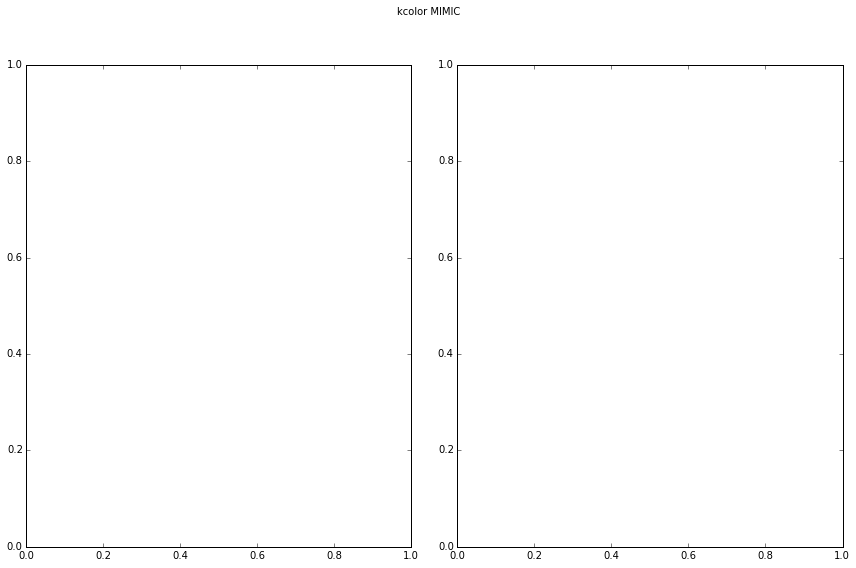

In [21]:
plot_all(prob_name, "MIMIC", hyperparams, {}, mimic_ret)